In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import log_loss
from keras.optimizers import SGD
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [2]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [3]:
x_train = np.load("datasets/normal/x_train_200.npy")
y_train = np.load("datasets/normal/y_train_200.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [4]:
x_val = np.load("datasets/normal/x_val_200.npy")
y_val = np.load("datasets/normal/y_val_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [5]:
x_test = np.load("datasets/normal/x_test_200.npy")
y_test = np.load("datasets/normal/y_test_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [6]:
img = x_train[50]
img.shape

(200, 200, 3)

In [7]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [8]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [9]:
def get_model_exp2_b():
    #model architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    #fix the optimizer
    sgd = SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True) #try varying this for your task and see the best fit

    #compile the model
    model.compile(optimizer=sgd,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall, f1, matthews_correlation, auc])

    return model

model = None
model=get_model_exp2_b()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
__________

In [10]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [11]:
model=get_model_exp2_b()
path_model='raja_exp2.h5'  

# set the learning rate
#K.set_value(model.optimizer.lr, 0.01) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=300, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            )

Train on 22046 samples, validate on 2756 samples
Epoch 1/300
22046/22046 [==============================] - 39s 2ms/step - loss: 2.1077 - acc: 0.5744 - precision: 0.5891 - recall: 0.5741 - f1: 0.5588 - matthews_correlation: 0.1578 - auc: 0.5779 - val_loss: 1.3548 - val_acc: 0.5646 - val_precision: 0.5510 - val_recall: 0.6770 - val_f1: 0.6033 - val_matthews_correlation: 0.1355 - val_auc: 0.593037 - precision: 0.5890 - recall: 0.5739 - f1: 0.5581 - matthews_corre
Epoch 2/300
22046/22046 [==============================] - 37s 2ms/step - loss: 1.1788 - acc: 0.5944 - precision: 0.6036 - recall: 0.5884 - f1: 0.5826 - matthews_correlation: 0.1933 - auc: 0.6003 - val_loss: 1.0746 - val_acc: 0.6023 - val_precision: 0.5802 - val_recall: 0.7407 - val_f1: 0.6456 - val_matthews_correlation: 0.2210 - val_auc: 0.6069on: 0.6035 - recall: 0.5881 - f1: 0.5824 - matthews_correlation: 0.1932 - auc: 0.
Epoch 3/300
22046/22046 [==============================] - 37s 2ms/step - loss: 1.0050 - acc: 0.6080 - pr

22046/22046 [==============================] - 37s 2ms/step - loss: 0.6948 - acc: 0.6661 - precision: 0.6745 - recall: 0.6610 - f1: 0.6598 - matthews_correlation: 0.3358 - auc: 0.6725 - val_loss: 0.7418 - val_acc: 0.6553 - val_precision: 0.6247 - val_recall: 0.7681 - val_f1: 0.6857 - val_matthews_correlation: 0.3208 - val_auc: 0.6744- acc: 0.6652 - precision: 0.6725 - recall: 0.6579 - f1: 0.6576 - matthews_co - ETA: 13s - loss: 0.6995 - acc: 0.6650 - precision: 0.6725 - recall: 0.6564 - f1: 0.6568 - matthews_correlation: 0.3322 - auc: 0.67 - ETA: 13s - loss: 0.6985 - acc: 0.6658 - precision: 0.6741 - r - ETA: 8s - loss: 0.6980 - ac - ETA: 2s - loss: 0.6940 - acc: 0.6660 - precision: 0.6750 - recall: 0.6627 - f1: 0.6606 - matthews_cor - ETA: 1s - loss: 0.6934 - acc: 0.6663 - precision: 0.6744 - recall: 0.6614 - f1: 0.6598 - matthews_correlation: 0.33 - ETA: 0s - loss: 0.6946 - acc: 0.6658 - precision: 0.6737 - recall: 0.6610 - f1: 0.6594 - matthews_correlation: 0.3353 - a
Epoch 14/300
2

22046/22046 [==============================] - 37s 2ms/step - loss: 0.6157 - acc: 0.6979 - precision: 0.7041 - recall: 0.6915 - f1: 0.6909 - matthews_correlation: 0.3994 - auc: 0.7028 - val_loss: 0.6542 - val_acc: 0.6807 - val_precision: 0.6836 - val_recall: 0.6709 - val_f1: 0.6723 - val_matthews_correlation: 0.3657 - val_auc: 0.7041- acc: 0.6860 - precision: 0.6953 - ETA: 24s - loss: 0.6183 - acc: 0.6955 - precis - ETA: 16s - loss: 0.6202 - acc: 0.6937 - precision: 0.7000 - recall: 0.6827 - f1: 0.6839 - matthews_cor - ETA: 13s - loss: 0.6192 - acc: 0.6940 - precision: 0.7004 - recall: 0.6838 - f - ETA: 8s - loss: 0.6203 - acc: 0.6952 - precision: 0.7019 - recall: 0.6857 - f1: 0.6866 - matthews_correlation: 0.3931 - ETA: 8s - loss: 0.6192 - acc: 0.6958 - precision: 0.7028 - recall: 0.6868 - f1: 0.6874 - matthews_correlation: 0. - ETA: 7s - loss: 0.6187 - acc: 0.6960 - precision: 0.7032 - recall: 0.6873 - f1: 0.6880 - matthews - ETA: 5s - loss: 0.6158 - acc: 0.6974 - precision: 0.7040 -

22046/22046 [==============================] - 37s 2ms/step - loss: 0.5762 - acc: 0.7188 - precision: 0.7266 - recall: 0.7113 - f1: 0.7130 - matthews_correlation: 0.4405 - auc: 0.7205 - val_loss: 0.7261 - val_acc: 0.6560 - val_precision: 0.7764 - val_recall: 0.4335 - val_f1: 0.5507 - val_matthews_correlation: 0.3487 - val_auc: 0.7214.7172 - precision: 0.7258 - recall: 0.7076 - f1: 0.7107 - ma - ETA: 5s - loss: 0.5753 - acc: 0.7183 - precision: 0.7270 - recall: 0.7086 - f1: 0.7118 - matthews_correlation: 0.4396 - auc:  - ETA: 5s - loss: 0.5753 - acc: 0.7183 - precision: 0.7270 - recall: 0.7086 - f1: 0.7117 - matthews_correlation: 0.4397 - a - ETA: 4s - loss: 0.5766 - acc: 0
Epoch 32/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.5727 - acc: 0.7182 - precision: 0.7270 - recall: 0.7057 - f1: 0.7097 - matthews_correlation: 0.4373 - auc: 0.7223 - val_loss: 0.6566 - val_acc: 0.6821 - val_precision: 0.6440 - val_recall: 0.8093 - val_f1: 0.7135 - val_matthews_correla

22046/22046 [==============================] - 37s 2ms/step - loss: 0.5442 - acc: 0.7359 - precision: 0.7436 - recall: 0.7302 - f1: 0.7313 - matthews_correlation: 0.4748 - auc: 0.7366 - val_loss: 0.6160 - val_acc: 0.6992 - val_precision: 0.6686 - val_recall: 0.7837 - val_f1: 0.7178 - val_matthews_correlation: 0.4078 - val_auc: 0.7374: 0.7283 - precision: 0.7251 - reca - ETA: 24s - loss: 0.5541 - acc: 0.7341 - precision: 0.7401 - recall: 0.7271 - f1: 0.7284 - - ETA: 19s - loss: 0.5511 - acc: 0.7374 - precision: 0.7434 - recall: 0.7275 - f1: 0.7 - ETA: 14s - loss: 0.5507 - acc: 0.7349 - precision: 0.7427 - rec - ETA: 2s - loss: 0.5439 - acc: 0.7368 - precision: 0.7448 - recall: 0.7330 - f1: 0.7332 - matthews_correlation: 0.4770 - a - ETA: 1s - loss: 0.5437 - acc: 0.7367 - precision: 0.7440 - recall: 0.7321 - f1: 0.7324 - matthews_correlation: 0.4766 - - ETA: 1s - loss: 0.5441 - acc: 0.7360 - precision: 0.7432 - recall: 0.7307 - f1: 0.7313 - matthews_correlation: 0.47 - ETA: 0s - loss: 0.

22046/22046 [==============================] - 37s 2ms/step - loss: 0.5199 - acc: 0.7509 - precision: 0.7589 - recall: 0.7466 - f1: 0.7470 - matthews_correlation: 0.5063 - auc: 0.7490 - val_loss: 0.6074 - val_acc: 0.7065 - val_precision: 0.7690 - val_recall: 0.5871 - val_f1: 0.6609 - val_matthews_correlation: 0.4278 - val_auc: 0.7497 - f1:  - ETA: 6s - loss: 0.5199 - acc: 0.7515 - precision: 0.7596 - recall: 0.7474 - f1: 0.7476 - matthews - ETA: 5s - loss: 0.5198 - 
Epoch 49/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.5160 - acc: 0.7528 - precision: 0.7609 - recall: 0.7436 - f1: 0.7466 - matthews_correlation: 0.5085 - auc: 0.7504 - val_loss: 0.5827 - val_acc: 0.7104 - val_precision: 0.7089 - val_recall: 0.7133 - val_f1: 0.7067 - val_matthews_correlation: 0.4244 - val_auc: 0.75110.7624 - recall: 0.7412 - - ETA: 16s - loss: 0.5173 - acc: 0.7521 - precision: 0.7600 - recall: 0.7382 - f1: 0.7430 - ETA: 12s - loss: 0.5193 - acc: 0.7501 - precision: 0.7567 - r -

22046/22046 [==============================] - 37s 2ms/step - loss: 0.4893 - acc: 0.7696 - precision: 0.7792 - recall: 0.7591 - f1: 0.7639 - matthews_correlation: 0.5426 - auc: 0.7642 - val_loss: 0.5595 - val_acc: 0.7268 - val_precision: 0.7153 - val_recall: 0.7492 - val_f1: 0.7283 - val_matthews_correlation: 0.4561 - val_auc: 0.7648
Epoch 60/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.4874 - acc: 0.7714 - precision: 0.7785 - recall: 0.7644 - f1: 0.7666 - matthews_correlation: 0.5460 - auc: 0.7655 - val_loss: 0.5551 - val_acc: 0.7293 - val_precision: 0.7328 - val_recall: 0.7187 - val_f1: 0.7218 - val_matthews_correlation: 0.4611 - val_auc: 0.7661
Epoch 61/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.4846 - acc: 0.7725 - precision: 0.7820 - recall: 0.7640 - f1: 0.7680 - matthews_correlation: 0.5475 - auc: 0.7668 - val_loss: 0.5593 - val_acc: 0.7264 - val_precision: 0.7055 - val_recall: 0.7720 - val_f1: 0.7340 - val_matthews_corr

22046/22046 [==============================] - 37s 2ms/step - loss: 0.4574 - acc: 0.7892 - precision: 0.7983 - recall: 0.7784 - f1: 0.7841 - matthews_correlation: 0.5799 - auc: 0.7801 - val_loss: 0.5352 - val_acc: 0.7329 - val_precision: 0.7515 - val_recall: 0.6901 - val_f1: 0.7155 - val_matthews_correlation: 0.4692 - val_auc: 0.7807 0.7762 - f1: 0.7818 - matthews_correla - ETA: 10s - loss: 0.4569 - acc: 0.7886 - precision: 0.7969 - recall: 0.7766 - f1: 0.7824 - matthews_correlation: 0.5791 - auc: 0.7 - ETA: 10s - loss: 0.4574 - acc: 0.7887 - precision: 0.7970 - recall: 0.7766 - f1 - - ETA: 1s - loss: 0.4587 - acc: 0.7888 - precision: 0.7977 - recall: 0.7791 - f1: 0.7842 - matthews_correlation: 0.57 - ETA: 0s - loss: 0.4576 - acc: 0.7891 - precision: 0.7982 - recall: 0.7782 - f1: 0.7840 - matthews_correlation: 0.5797 - auc: 
Epoch 73/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.4563 - acc: 0.7882 - precision: 0.7985 - recall: 0.7791 - f1: 0.7839 - matthews_

22046/22046 [==============================] - 37s 2ms/step - loss: 0.4313 - acc: 0.8054 - precision: 0.8147 - recall: 0.7959 - f1: 0.8006 - matthews_correlation: 0.6133 - auc: 0.7923 - val_loss: 0.5134 - val_acc: 0.7544 - val_precision: 0.7632 - val_recall: 0.7358 - val_f1: 0.7446 - val_matthews_correlation: 0.5128 - val_auc: 0.79288006 - matthews_correlation: 0.6143 - auc:  - ETA: 1s - loss: 0.4315 - acc: 0.8056 - precision: 0.8149 - recall: 0.7961 - f1: 0.8007 - matthews_correlation: 0.6139 - auc:  - ETA: 0s - loss: 0.4316 - acc: 0.8056 - precision: 0.8149 - recall: 0.7959 - f1: 0.8006 - matthews_correlation: 0.61 - ETA: 0s - loss: 0.4316 - acc: 0.8053 - precision: 0.8145 - recall: 0.7957 - f1: 0.8004 - matthews_correlation: 0.6130 - auc: 0.
Epoch 84/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.4292 - acc: 0.8036 - precision: 0.8140 - recall: 0.7921 - f1: 0.7985 - matthews_correlation: 0.6096 - auc: 0.7934 - val_loss: 0.5293 - val_acc: 0.7507 - val_preci

22046/22046 [==============================] - 37s 2ms/step - loss: 0.4087 - acc: 0.8176 - precision: 0.8294 - recall: 0.8048 - f1: 0.8131 - matthews_correlation: 0.6377 - auc: 0.8036 - val_loss: 0.4926 - val_acc: 0.7681 - val_precision: 0.7533 - val_recall: 0.7914 - val_f1: 0.7688 - val_matthews_correlation: 0.5383 - val_auc: 0.8041116 - matthews_correlation: 0.6 - ETA: 10s - - ETA: 4s - loss: 0.4083 - acc: 0.8178 - precision:
Epoch 95/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.4060 - acc: 0.8196 - precision: 0.8311 - recall: 0.8081 - f1: 0.8157 - matthews_correlation: 0.6419 - auc: 0.8046 - val_loss: 0.4897 - val_acc: 0.7674 - val_precision: 0.7677 - val_recall: 0.7610 - val_f1: 0.7612 - val_matthews_correlation: 0.5362 - val_auc: 0.8051cc: 0.8203 - precision: 0.8327 - recall: 0.8041 - f1: 0.8144 - - ETA: 23s - loss: 0.4053 - acc: 0.8182 - precision: 0.8306 - recall: 0.8085 - f1: 0.8154 - matthe - ETA: 19s - loss: 0.4038 - acc: 0.8207 - precision: 0.830

22046/22046 [==============================] - 37s 2ms/step - loss: 0.3847 - acc: 0.8291 - precision: 0.8410 - recall: 0.8184 - f1: 0.8256 - matthews_correlation: 0.6614 - auc: 0.8141 - val_loss: 0.4705 - val_acc: 0.7798 - val_precision: 0.7907 - val_recall: 0.7567 - val_f1: 0.7697 - val_matthews_correlation: 0.5626 - val_auc: 0.8146 - matthews_c - ETA: 23s - loss: 0.3919 - acc: 0.8213 - precision: 0.8305 - recall: 0.8091 - f1: 0.8157 - matt - ETA: 19s - loss: 0.3889 - acc: 0.8223 - precision: 0.8324 - recall: 0.8100 - f1: 0.8173 - matthews_correlation: 0.647 - ETA: 17s - loss - ETA: 8s - loss: 0.3859 - acc: 0.8269 - precision: 0.8380 - recall: 0.8166 - f1: 0.823 - ETA: 5s - loss: 0.3860 - acc: 0.8265 - precision: 0.837 - ETA: 1s - loss: 0.3848 - acc: 0.8282 - precision: 0.8394 - recall: 0.8185 - f1: 0.8250 - ma
Epoch 106/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.3819 - acc: 0.8332 - precision: 0.8463 - recall: 0.8201 - f1: 0.8291 - matthews_correlation:

22046/22046 [==============================] - 37s 2ms/step - loss: 0.3579 - acc: 0.8475 - precision: 0.8617 - recall: 0.8322 - f1: 0.8432 - matthews_correlation: 0.6976 - auc: 0.8250 - val_loss: 0.4445 - val_acc: 0.7990 - val_precision: 0.8023 - val_recall: 0.7888 - val_f1: 0.7926 - val_matthews_correlation: 0.5996 - val_auc: 0.8255: 5s - loss: 0.3593 - acc: 0.8466 - precision: 0.8609 - recall: 0.8295 - f1: 0.8413 - matt - ETA: 3s - loss: 0.3593 - acc: 0.8474 - precision: 0.8620 - recall: 0.8301 - f1: 0.8422 - matthews_correlation: 0.6976 - auc: 0.82 - ETA: 3s - loss: 0.3595 - acc: 0.8472 - precision: 0.8618 - recall: 0.8303 - f1: 0.8422 - matthews_correlation: 0.6972 - auc: 0. - ETA: 3s - loss: 0.3597 - acc: 0.8471 - precision: 0.8614 - recall: 0.8307 - f1: 0.8422 - matthews_correlation: 0.6969 - - ETA: 2s - loss: 0.3590 - acc: 0.8474 - precision: 0.8616 - recall: 0.8315 - f1: 0.8427 - matthews_correlati - ETA: 1s - loss: 0.3576 - acc: 0.8482 - precision: 0.8627 - recall: 0.8320 - f1

22046/22046 [==============================] - 36s 2ms/step - loss: 0.3307 - acc: 0.8628 - precision: 0.8747 - recall: 0.8501 - f1: 0.8589 - matthews_correlation: 0.7277 - auc: 0.8354 - val_loss: 0.4400 - val_acc: 0.7983 - val_precision: 0.7611 - val_recall: 0.8655 - val_f1: 0.8074 - val_matthews_correlation: 0.6034 - val_auc: 0.8358sion: 0.8740 - recall: 0.8514 - f1: 0.8593 - matthews_correlation: 0.7274 - auc - ETA: 29s - loss: 0.3282 - acc: 0.8619 - precision: 0.8743 - recall: 0.8506 - f1: 0.8591 - matthews_correlation: 0.7266 - ETA: 28s - loss: 0.3335 - acc: 0.8586 - precision: 0.8691 - recall: 0. - ETA: 22s - loss: 0.3311 - acc: 0.8594 - precision: 0.8669 - recall: 0.8479 - f1: 0.8543 - matthews_correlation: 0.7201 - auc: 0. - ETA: 21s - loss: 0.3307 - acc: 0.8592 - precision: 0.8681 - recall: 0.8463 - f1: 0.8540  - ETA: 17s - loss: 0.3335 - acc: 0.8597 - precision: 0.8687 - recall: 0.8491 - f1: 0.8555 - matthews_correlation: 0 - ETA: 15s - loss: 0.3345 - acc: 0.8590 - precision: 

22046/22046 [==============================] - 36s 2ms/step - loss: 0.3172 - acc: 0.8710 - precision: 0.8830 - recall: 0.8579 - f1: 0.8679 - matthews_correlation: 0.7433 - auc: 0.8403 - val_loss: 0.4158 - val_acc: 0.8171 - val_precision: 0.8508 - val_recall: 0.7673 - val_f1: 0.8036 - val_matthews_correlation: 0.6395 - val_auc: 0.8407l: 0.8499 - f1: 0.8648  - ETA: 23s - loss: 0.3190 - acc: 0.8708 - precision: 0.8862 - recall: 0.8567 - f1: 0.8683 - matthews_correlat - ETA: 20s - loss: 0.3202 - acc: 0.8701 - precision: 0 - ETA: 12s - loss: 0.3206 - acc: 0.8694 - precision: 0.8823 - recall: 0.8559 - f1: 0.8664 - ma - ETA: 9s - loss: 0.3170 - acc: 0.8708 - precision: 0.8828 - recall: 0.8581 - f1: 0.8678 - matthews_correlation: 0.7431 - auc: 0.84 - ETA: 9s - loss: 0.3171 - acc: 0.8707 - precision: 0.8829 - recall: 0.8578 - f1: 0.8677 - matthews_correlati - ETA: 1s - loss: 0.3177 - acc: 0.8705 - precision: 0.8826 - recall: 0.8570 - f1: 0.8672 - matthews
Epoch 136/300
22046/22046 [============

22046/22046 [==============================] - 36s 2ms/step - loss: 0.3048 - acc: 0.8760 - precision: 0.8892 - recall: 0.8624 - f1: 0.8727 - matthews_correlation: 0.7540 - auc: 0.8460 - val_loss: 0.3990 - val_acc: 0.8258 - val_precision: 0.8542 - val_recall: 0.7852 - val_f1: 0.8148 - val_matthews_correlation: 0.6566 - val_auc: 0.84640.8829 - recall: 0.8584 - f1: 0.8676 - matthews_correlation: 0.7439 - a - ETA: 14s - loss: 0.3091 - acc: 0.8730 - precision: 0.8847 - recall: 0.8608 - f1: 0.8697 - matthews_correlation:  - ETA: 12s - loss: 0.3087 - acc: 0.8737 - precision: 0.8861 - recall: 0.8607 - f1: 0.8702 - matthews_correlati - ETA: 10s - loss: 0.3071 - acc: 0.8747 - precision: 0.8859 - recall: 0.8628 - f1: 0.8713 - matthews_correlation: 0.7509 - auc - ETA: 9s - loss: 0.3067 - acc: 0.8753 - precision: 0.8870 - recall: 0.86
Epoch 143/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.3032 - acc: 0.8783 - precision: 0.8909 - recall: 0.8644 - f1: 0.8744 - matthews_co

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2921 - acc: 0.8851 - precision: 0.8977 - recall: 0.8716 - f1: 0.8824 - matthews_correlation: 0.7715 - auc: 0.8506 - val_loss: 0.3993 - val_acc: 0.8309 - val_precision: 0.8045 - val_recall: 0.8714 - val_f1: 0.8344 - val_matthews_correlation: 0.6650 - val_auc: 0.851012 - acc: 0.8861 - precision: 0.9011 - recall: 0.8692 - f1: 0.8825 - matthews_correlation: 0.7739 - auc: 0 - ETA: 31s - loss: 0.3021 - acc: 0.8842 - precision: 0.8977 - recall: 0.8691 - f1: 0.8807 - matthews_correlation: 0.7706  - ETA: 29s - loss: 0.2966 - acc: 0.8850 - precision: 0.8938 - recall: 0.8653 - f1: 0.8772 - matthews_correlation: 0 - ETA: 27s - loss: 0.2958 - acc: 0.8840 - precision: 0.8933 - ETA: 20s - loss: 0.2987 - acc: 0.8835 - precision: 0.8958 - recall: 0.8693 - f1: 0.8804 - matthews_correlation: 0.7679 - auc - ETA: 19s - loss: 0.2985 - acc: 0.8835 - precision: 0.8967 - recall: 0.8686  - ETA: 14s - loss: 0.2955 - acc: 0.8850 - precision: 0.

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2823 - acc: 0.8891 - precision: 0.9026 - recall: 0.8751 - f1: 0.8861 - matthews_correlation: 0.7800 - auc: 0.8552 - val_loss: 0.3794 - val_acc: 0.8345 - val_precision: 0.8474 - val_recall: 0.8162 - val_f1: 0.8288 - val_matthews_correlation: 0.6715 - val_auc: 0.8555855 - precision: 0.9001 - recal - ETA: 22s - loss: 0.2787 - acc: 0.8900 - precision: 0.9026 - recall: 0.8770 - ETA: 16s - loss: 0.2826 - acc: 0.8884 - precision: 0.9019 - recall: 0.8755 - f1: 0.8862 - matthews_correlation: 0.7783 - auc: 0.855 - ETA: 16s - loss: 0.2822 - acc: 0.8886 - precision: 0.9017 - recall: 0.8760 - f1: 0.8863 - matthews_correlation: 0.77 - ETA: 15s - loss: 0.2820 - acc: 0.8882 - precision: 0.9014 - recall: 0.8762 - f1: 0.8861 - matthews_corr - ETA: 12s - loss: 0.2814 - acc: 0.8898 - precision: 0.9040 - recall: 0.8758 - f1: 0.8871 - matthews_correlation: 0.7814 - auc:  - ETA: 11s - loss: 0.2809 - acc: 0.8902 - precision: 0.9041 - recall

22046/22046 [==============================] - 37s 2ms/step - loss: 0.2644 - acc: 0.8991 - precision: 0.9119 - recall: 0.8857 - f1: 0.8967 - matthews_correlation: 0.7992 - auc: 0.8624 - val_loss: 0.3659 - val_acc: 0.8480 - val_precision: 0.8370 - val_recall: 0.8616 - val_f1: 0.8470 - val_matthews_correlation: 0.6973 - val_auc: 0.8627 - acc: 0.8891 - precision: 0. - ETA: 25s - loss: 0.2636  - ETA: 14s - loss: 0.2627 - acc: 0.9020 - precision: 0.9148 - recall: 0.8876 - f1: 0.8993 - matthews_correlation: 0.8048 - - ETA: 13s - loss: 0.2621 - acc: 0.9021 - precision: 0.9147 - recall: 0.8879 -  - ETA: 8s - loss: 0.2626 - acc: 0.9005 - precision: 0.9137 - recall: 0.8868 - f1: 0.8982 - matthews_correla - ETA: 7s - loss: 0.2616 - acc: 0.9007 - precision: 0.9140 - recall: 0.8868 - f1: 0.8984 - matthews_correlation: 0.8023 - auc:  - ETA: 7s - loss: 0.2623 - acc: 0.9006 - precision: 0.9139 - recall: 0.8869 - f1: 0.8984 - matthews_c - ETA: 5s - loss: 0.2619 - acc: 0.9006 - precision: 0.9135 - recal

22046/22046 [==============================] - 37s 2ms/step - loss: 0.2496 - acc: 0.9074 - precision: 0.9200 - recall: 0.8941 - f1: 0.9049 - matthews_correlation: 0.8159 - auc: 0.8698 - val_loss: 0.3543 - val_acc: 0.8570 - val_precision: 0.8426 - val_recall: 0.8748 - val_f1: 0.8565 - val_matthews_correlation: 0.7152 - val_auc: 0.8701- acc: 0.9245 - precision: 0.9373 - recall:  - ETA: 26s - loss: 0.2518 - acc: 0.9099 - precision: 0.9244 - recall: 0.8956 - f1: 0.9076 - matthews_correlation: 0.8223 - auc: - ETA: 26s - loss: 0.2492 - acc: - ETA: 6s
Epoch 176/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.2468 - acc: 0.9088 - precision: 0.9208 - recall: 0.8957 - f1: 0.9063 - matthews_correlation: 0.8187 - auc: 0.8705 - val_loss: 0.3488 - val_acc: 0.8585 - val_precision: 0.8776 - val_recall: 0.8321 - val_f1: 0.8523 - val_matthews_correlation: 0.7189 - val_auc: 0.8708c: 0.9002 - precision: 0.9056 - recall: 0.8902 - f1: 0.8958 - matthews_correl - ETA: 29s - loss: 0.2

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2390 - acc: 0.9118 - precision: 0.9244 - recall: 0.8987 - f1: 0.9099 - matthews_correlation: 0.8245 - auc: 0.8743 - val_loss: 0.3417 - val_acc: 0.8596 - val_precision: 0.8696 - val_recall: 0.8451 - val_f1: 0.8549 - val_matthews_correlation: 0.7211 - val_auc: 0.8746306 - acc: 0.9219 - precision: 0.9350 - recall: 0.9128 - f1: 0.9231 - matthews_correlation: 0.8438 - auc: 0 - ETA: 32s - loss: 0.2178 - acc: 0.9286 - precision: 0.9468 - recall: 0.9126 - f1: 0.9286 - matthews_correlation: 0.8579 - auc:  - ETA: 31s - loss: 0.2212 - acc: 0.9187 - precision: 0.9357 - recall: 0.9061 - f1: 0.9193 - matthews_correlation: 0.8378 - auc: 0 - ETA: 31s - loss: 0.2211 - acc: 0.91 - ETA: 21s - loss: 0.2348 - acc: 0.9132 - precision: 0.9264 - recall: 0.8983 - f1: 0.9108 - matthews_correlation: 0.8268 -  - ETA: 20s - loss: 0.2360 - acc: 0.9127 - precision: 0.9255 - recall: 0.8981 - f1: 0.9103 - matthe - ETA: 17s - loss: 0.2346 - acc: 0.91

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2328 - acc: 0.9136 - precision: 0.9273 - recall: 0.8997 - f1: 0.9114 - matthews_correlation: 0.8282 - auc: 0.8779 - val_loss: 0.3450 - val_acc: 0.8578 - val_precision: 0.8437 - val_recall: 0.8768 - val_f1: 0.8576 - val_matthews_correlation: 0.7174 - val_auc: 0.8782 0.9356 - recall: 0.9007 - - ETA: 21s - loss: 0.2311 - acc: 0.9152 - precision: 0.9294 - recall: 0.902 - ET
Epoch 189/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.2320 - acc: 0.9165 - precision: 0.9295 - recall: 0.9027 - f1: 0.9143 - matthews_correlation: 0.8339 - auc: 0.8785 - val_loss: 0.3354 - val_acc: 0.8618 - val_precision: 0.8879 - val_recall: 0.8290 - val_f1: 0.8552 - val_matthews_correlation: 0.7269 - val_auc: 0.8788
Epoch 190/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.2299 - acc: 0.9171 - precision: 0.9289 - recall: 0.9046 - f1: 0.9150 - matthews_correlation: 0.8355 - auc: 0.8791 - val_los

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2239 - acc: 0.9189 - precision: 0.9317 - recall: 0.9058 - f1: 0.9168 - matthews_correlation: 0.8391 - auc: 0.8826 - val_loss: 0.3377 - val_acc: 0.8636 - val_precision: 0.8432 - val_recall: 0.8915 - val_f1: 0.8648 - val_matthews_correlation: 0.7291 - val_auc: 0.88292 - acc: 0.9209 - precision: 0.9255 - recall: 0.9119 - f1: 0.9168 - matthews_correlation: 0.8427 - auc: 0 - ETA: 30s - loss: 0.2225 - acc: 0.9239 - precision: 0.9280 - recall: 0.9163 - f1: 0.9205 - matthews_correlation - ETA: 27s - los - ETA: 16s - loss: 0.2217 - acc: 0.9184 - precision: 0.9300 - recall: 0.9047 - f1: 0.9152 - matthews_correlation: 0.8385  - ETA: 14s - loss: 0.2214 - acc: 0.9185 - precision: 0.9294 - recall: 0.9047 - f1: 0.9150 - matt - ETA: 11s - loss: 0.2259 - acc: 0.9182 - precision: 0.9299 - recall: 0.9046 - f1: 0.9151 - matthews_correlation: 0.838 - ETA: 9s - loss: 0.2240 - acc: 0.9193 - precision: 0.9308 - recall: 0.9062 - f1: 0.9164 -

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2152 - acc: 0.9233 - precision: 0.9353 - recall: 0.9104 - f1: 0.9210 - matthews_correlation: 0.8475 - auc: 0.8870 - val_loss: 0.3268 - val_acc: 0.8690 - val_precision: 0.8559 - val_recall: 0.8850 - val_f1: 0.8684 - val_matthews_correlation: 0.7390 - val_auc: 0.88726 - acc: 0.9253 - precision: 0.9385 - recall: 0.9141 - f1: 0.9254 - matthews_correlation: 0.8502 - auc: 0.886 - ETA: 32s - loss: 0.1937 - acc: 0.9219 - precision: 0.9375 - recall: 0.9062 - f1: 0.9209 - matthews_correlation: 0.843 - ETA: 31s - loss: 0.2033 - acc: 0.9249 - precision: 0.9377 - recall: 0.9037 - f1: 0.9189 - matthews_correlation: 0.8491 - auc: 0.8 - ETA: 30s - loss: 0.2032 - acc: 0.9251 - precision: 0.9366 - recall: 0.9064 - f1: 0.9197 - matthews - ETA: 27s - loss: 0.2091 - acc: 0.9236 - precision: 0.9347 - recall: 0.9091 - f1: 0.9198 - matthews_correlation: 0.8481 - auc: 0.88 - ETA: 27s - loss: 0.2083 - acc: 0.9238 - precision: 0.9340 - recall:

22046/22046 [==============================] - 36s 2ms/step - loss: 0.2099 - acc: 0.9266 - precision: 0.9379 - recall: 0.9152 - f1: 0.9249 - matthews_correlation: 0.8543 - auc: 0.8901 - val_loss: 0.3429 - val_acc: 0.8570 - val_precision: 0.9252 - val_recall: 0.7789 - val_f1: 0.8429 - val_matthews_correlation: 0.7252 - val_auc: 0.8903352 - recall: 0.9228 - f1: 0.9275 - matthews_correlation: 0.8552 - auc: 0.88 - ETA: 27s - loss: 0.2099 - acc: 0.9273 - precision: 0.9357 - recall: 0.9231 - f1: 0.9279 - matthews - ETA: 24s - loss: 0.2131 - acc: 0.9269 - precision: 0.9358 - recall: 0.9187 - f1: 0.9259 - matthews_correlation: 0.8543 - auc: 0.88 - ETA: 24s - loss: 0.2134 - acc: 0.9263 - precision: 0.9351 - recall: 0.9183 - f1: 0.9252 - matthews_correlation: 0.8 - ETA: 22s - loss: 0.2140 - acc: 0.9260 - precision: 0.9350 - recall: 0.9178 - f1: 0.9249 - matthews_corr - ETA: 19s - loss: 0.2137 - acc: 0.9261 - precision: 0.9357 - recall: 0.9159 - f1: 0.9244 - matthews_correlation: 0.8529 - a - ETA

22046/22046 [==============================] - 38s 2ms/step - loss: 0.2035 - acc: 0.9291 - precision: 0.9406 - recall: 0.9172 - f1: 0.9274 - matthews_correlation: 0.8590 - auc: 0.8931 - val_loss: 0.3130 - val_acc: 0.8774 - val_precision: 0.8851 - val_recall: 0.8660 - val_f1: 0.8737 - val_matthews_correlation: 0.7556 - val_auc: 0.8933
Epoch 217/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.2025 - acc: 0.9284 - precision: 0.9406 - recall: 0.9163 - f1: 0.9269 - matthews_correlation: 0.8579 - auc: 0.8935 - val_loss: 0.3113 - val_acc: 0.8734 - val_precision: 0.8911 - val_recall: 0.8496 - val_f1: 0.8680 - val_matthews_correlation: 0.7486 - val_auc: 0.8938cision: 0.9393 - recall: 0.9151 - ETA: 3s - loss: 0.2035 - acc: 0.9279 - precision: 0.9407 - recall: 0.9152 - f1: 0.9264 - matthews_correlation: 0.8570 - auc:  - ETA: 3s - loss: 0.2034 - acc: 0.9279 - precision: 0.9404 - recall: 0.9153 - f1: 0.9263 -  - ETA: 1s - loss: 0.2028 - acc: 0.9284 - precision: 0.9405 - re

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1976 - acc: 0.9321 - precision: 0.9426 - recall: 0.9209 - f1: 0.9302 - matthews_correlation: 0.8650 - auc: 0.8964 - val_loss: 0.3134 - val_acc: 0.8748 - val_precision: 0.9123 - val_recall: 0.8298 - val_f1: 0.8666 - val_matthews_correlation: 0.7545 - val_auc: 0.8966cc: 0.9330 - precision: 0.9500 - recall: 0.91 - ETA: 25s - loss: 0.1970 - acc: 0.9313 - precision: 0.9410 - recall: 0.9204 - f1: 0.9293 - matthews_correlation: 0.86 - ETA: 23s - loss: 0.1993 - acc: 0.9309 - precision: 0.9412 - recall: 0.9199 - f1: 0.9291 - matthews_correlation: 0.8626 - au - ETA: 22s - loss: 0.2019 - acc: 0.9295 - precision: 0.9404 - recall: 0.9171 - f1: 0.9273 - matt - ETA: 18s - loss: 0.2016 - acc: 0.9294 - precision: 0.9424 - recall: 0.9160 - f1: 0.9278 - matthews_correlation: 0.8597 - auc - ETA: 18s - loss: 0.2016 - acc: 0.9302 - precision: 0.9432 - recall: 0.9165 - f1: 0.9284 - matthews_cor - ETA: 15s - loss: 0.2001 - acc: 0.9320 - pre

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1928 - acc: 0.9331 - precision: 0.9445 - recall: 0.9218 - f1: 0.9317 - matthews_correlation: 0.8670 - auc: 0.8987 - val_loss: 0.3088 - val_acc: 0.8792 - val_precision: 0.8754 - val_recall: 0.8831 - val_f1: 0.8775 - val_matthews_correlation: 0.7590 - val_auc: 0.8989- acc: 0.9339 - precision: 0.9469 - recall: 0.9203 - f1: 0.9319 - matthe - ETA: 27s - loss: 0.1935 - acc: 0.9299 - precision: 0.9435 - recall: 0.9144 - f1: 0.9272 - matthews_correlation: 0.861 - ETA: 25s - loss: 0.1984 - acc: 0.927 - ETA: 16s - loss: 0.1905 - acc: 0.9326 - precision: 0.9450 - recall: 0.9195 - f1: 0.9307 - matthews_correlation: 0.866 - ETA: 15s - loss: 0.1924 - acc: 0.9322 - precision: 0.9448 - recall: 0.9193 - f1: 0.9305 - matthews_corr - ETA: 12s - loss: 0.1904 - acc: 0.9337 - precision: 0.9454 - recall: 0.9217 - f1: 0.9321 - matthews_correlation: 0.868 - ETA: 10s - loss: 0.1909 - acc: 0.9334 - precision: 0.9453 - recall: 0.9215 - f1: 0.93

22046/22046 [==============================] - 37s 2ms/step - loss: 0.1871 - acc: 0.9342 - precision: 0.9449 - recall: 0.9234 - f1: 0.9327 - matthews_correlation: 0.8691 - auc: 0.9022 - val_loss: 0.3140 - val_acc: 0.8723 - val_precision: 0.9225 - val_recall: 0.8127 - val_f1: 0.8618 - val_matthews_correlation: 0.7510 - val_auc: 0.9024tion: 0.8687 - au - ETA: 20s - loss: 0.1913 - acc: 0.9336 - precision: 0.9435 - recall: 0.9227 - f1: 0.9316 - matthews_correlation: 0.8684 - a - ETA: 19s - loss: 0.1930 - acc: 0.9334 - precision: 0.9437 - recall: 0.9219 - f1: 0.9313 - matthews_ - ETA: 16s - loss: 0.1917 - acc: 0.9329 - precision: 0.9430 - recall: 0.9222 - f1: 0.9311 - matthews_correlation: 0.8669 - - ETA: 15s - loss: 0.1915 - acc: 0.9337 -  - ETA: 7s - loss: 0.1877 - acc: 0.9345 - prec - ETA: 3s - loss: 0.1887 - acc: 0.9338 - precision: 0.9447 - recall: 0.9230 - f1: 0.9324  - ETA: 1s - loss: 0.1881 - acc: 0.9338 - precision: 0.9442 - recall: 0.9232 - f1: 0.9323 - matthews_corre
Epoch 237/30

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1805 - acc: 0.9385 - precision: 0.9493 - recall: 0.9272 - f1: 0.9370 - matthews_correlation: 0.8775 - auc: 0.9051 - val_loss: 0.2988 - val_acc: 0.8875 - val_precision: 0.8911 - val_recall: 0.8818 - val_f1: 0.8848 - val_matthews_correlation: 0.7757 - val_auc: 0.9053370 - precision: 0.9454 - recall: 0.9270 - f1: 0.9348 - matthews_correlation: 0.8744 - auc: 0.90 - ETA: 24s - loss: 0.1852 - acc: 0.9372 - precision:  - ETA: 16s - loss: 0.1844 - acc: 0.9378 - precision: 0.9484 - recall: 0.9262 - f1: 0.9359 - matthews_correlation: 0 - ETA: 14s - loss: 0.1825 - acc: 0.9384 - precision: 0.9491 - recall: 0.9268 - f1: 0.9366 - matthews_correlation: 0.8771  - ETA: 12s - loss: 0.1840 - acc: 0.9381 - precision: 0.9488 - recall: 0.9270 - f1: 0.9366 - matthews_correl - ETA: 10s - loss: 0.1834 - acc: 0.9379 - precision: 0.9484 - recall: 0.9270 - f1: 0.9364 - matthews_correlation: 0.8761 - auc: 0.90 - ETA: 10s - loss: 0.1838 - acc: 0.

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1757 - acc: 0.9401 - precision: 0.9515 - recall: 0.9284 - f1: 0.9387 - matthews_correlation: 0.8808 - auc: 0.9079 - val_loss: 0.2968 - val_acc: 0.8886 - val_precision: 0.8769 - val_recall: 0.9039 - val_f1: 0.8885 - val_matthews_correlation: 0.7784 - val_auc: 0.90819 - precision: 0.9456 - recall: 0.9195 - f1: 0.9313 - matthews_correlation - ETA: 26s - loss: 0.1868 - acc: 0.9329 - precision: 0.9427 - recall: 0.9235 - f1: 0.9319 - matthews_correlation: 0.8660 - ETA: 25s - loss: 0.1833 - acc: 0.9340 - precision: 0.9442 - recall: 0.9227 - f1: 0.9323 - matthews_correlat - ETA: 23s - loss: 0.1780 - acc: 0.9369 - precision: 0.9480 - recall: 0.9243 - f1: - ETA: 17s - loss: 0.1814 - acc: 0.9365 - precision: 0.9480 - recall: 0.9251 - f1: 0.9351 - matthews_correlatio - ETA: 15s - loss: 0.1794 - acc: 0.9375 - precision: 0.9492 - recall: 0.9261 - f1: 0.9363 - matthews_correlation: 0.8758  - ETA: 14s - loss: 0.1786 - acc: 0.9375 - 

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1715 - acc: 0.9414 - precision: 0.9532 - recall: 0.9289 - f1: 0.9396 - matthews_correlation: 0.8834 - auc: 0.9106 - val_loss: 0.2923 - val_acc: 0.8890 - val_precision: 0.8836 - val_recall: 0.8954 - val_f1: 0.8876 - val_matthews_correlation: 0.7791 - val_auc: 0.9107A: 21s - loss: 0.1772 - acc: 0.9414 - precision: 0.9529 - recall: 0.9304 - f1: 0.9406 - m - ETA: 17s - loss: 0.1737 - acc: 0.9413 - precision: 0.9522 - recall: 0.9302 - f1: 0.9400 - mat - ETA: 4s - loss: 0.1710 - acc: 0
Epoch 258/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.1708 - acc: 0.9431 - precision: 0.9538 - recall: 0.9320 - f1: 0.9416 - matthews_correlation: 0.8869 - auc: 0.9109 - val_loss: 0.2956 - val_acc: 0.8915 - val_precision: 0.8818 - val_recall: 0.9036 - val_f1: 0.8909 - val_matthews_correlation: 0.7841 - val_auc: 0.91119445 - recall: 0.9219 - f1: 0.9315 - matthews_correlatio - ETA: 26s - loss: 0.1755 - acc: 0.9418

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1677 - acc: 0.9430 - precision: 0.9546 - recall: 0.9310 - f1: 0.9415 - matthews_correlation: 0.8866 - auc: 0.9131 - val_loss: 0.2997 - val_acc: 0.8882 - val_precision: 0.8710 - val_recall: 0.9106 - val_f1: 0.8888 - val_matthews_correlation: 0.7776 - val_auc: 0.9133 recall: 0.9339 - f1: 0.9444 - matthews_correlation: 0.8932 - auc:  - ETA: 16s - loss: 0.1639 - acc: 0.9459 - precision: 0.9568 - recall: 0.9336 - f1: 0.9440 - matthews_correlation: 0.8 - ETA: 14s - loss: 0.1648 - acc: 0.9460 - precision: 0.9573 - recall: 0.9342 - f1: 0.9445 - matthews_correlation: 0.8926 - auc - ETA: 13s - loss: 0.1660 - ac - ETA: 6s - loss: 0.1670 - acc: 0.9432 - precision: 0.9545 - recall: 0.9311 - f1: 0.9414 - matthe - ETA: 4s - loss: 0.1678 - acc: 0.9430 - precision: 0.9547 - recall: 0.9308 - f1: 0.9414 - matthews_correlation: 0.8867 - auc: 0. - ETA: 4s - loss: 0.1680 - acc: 0.9428 - precision: 0.9546 - recall: 0.9304 - f1: 0.9411 - ma

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1644 - acc: 0.9451 - precision: 0.9549 - recall: 0.9346 - f1: 0.9437 - matthews_correlation: 0.8909 - auc: 0.9148 - val_loss: 0.3009 - val_acc: 0.8861 - val_precision: 0.8643 - val_recall: 0.9150 - val_f1: 0.8873 - val_matthews_correlation: 0.7738 - val_auc: 0.9150acc: 0.9444 - precision: 0.9558 - recall: 0.9314 - f1: 0.9423 - matthews_correlation: 0.8904 - auc - ETA: 32s - loss: 0.1728 - acc: 0.9366 - precision: 0.9503 - recall: 0.9250 - f1: 0.9361 - matthews_corre - ETA: 29s - loss: 0.1606 - acc: 0.9472 - precision: 0.9597 - recall: 0.9363 - f1: 0.9471 - matthews_correlation: 0.8951 - auc: 0 - ETA: 29s - loss: 0.1590 - acc: 0.9469 - precision: 0.9579 - recall: 0.9372 - f1: 0.9467 - matthews_correlation: 0.8943 - auc: 0.91 - ETA: 28s - loss: 0.1680 - acc: 0.9450 - precision: 0.9566 - recall: 0.9336 - f1: 0.9441 - matthews_correlation: 0.8905 - auc: - ETA: 28s - loss: 0.1677 - acc: 0.9452 - precision: 0.9553 - recall

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1598 - acc: 0.9448 - precision: 0.9561 - recall: 0.9340 - f1: 0.9437 - matthews_correlation: 0.8905 - auc: 0.9175 - val_loss: 0.2964 - val_acc: 0.8926 - val_precision: 0.8785 - val_recall: 0.9108 - val_f1: 0.8928 - val_matthews_correlation: 0.7862 - val_auc: 0.9176ecall: 0.9295 - f1: 0.9371 - matthews_correlation - ETA: 24s - loss: 0.1692 - acc: 0.9399 - precision: 0.9505 - recall - ETA: 17s - loss: 0.1660 - acc: 0.9431 - precision: 0.9534 - recall: 0.9339 - f1: - ETA: 12s - loss: 0.1639 - acc: 0.9436 - precision: 0.9542 - recall: 0.9337 - f1: 0.9426 - matthews_correlation: 0.8883 -  - ETA: 11s - loss: 0.1624 - acc: 0.9442 - precision
Epoch 278/300
22046/22046 [==============================] - 36s 2ms/step - loss: 0.1597 - acc: 0.9463 - precision: 0.9559 - recall: 0.9365 - f1: 0.9450 - matthews_correlation: 0.8931 - auc: 0.9178 - val_loss: 0.2838 - val_acc: 0.8970 - val_precision: 0.8980 - val_recall: 0.8952 - val_f

22046/22046 [==============================] - 37s 2ms/step - loss: 0.1557 - acc: 0.9474 - precision: 0.9579 - recall: 0.9363 - f1: 0.9459 - matthews_correlation: 0.8952 - auc: 0.9200 - val_loss: 0.2858 - val_acc: 0.8951 - val_precision: 0.8862 - val_recall: 0.9065 - val_f1: 0.8945 - val_matthews_correlation: 0.7914 - val_auc: 0.9201orrelation:  - ETA: 23s - loss: 0.1515 - acc: 0.9487 - p - ETA: 14s - loss: 0.1 - ETA: 0s - loss: 0.1558 - acc: 0.9474 - precision: 0.9579 - recall: 0.9363 - f1: 0.9459 - matthews_correlation: 0.8952 - auc: 0.92
Epoch 286/300
22046/22046 [==============================] - 37s 2ms/step - loss: 0.1548 - acc: 0.9472 - precision: 0.9574 - recall: 0.9369 - f1: 0.9460 - matthews_correlation: 0.8950 - auc: 0.9203 - val_loss: 0.2929 - val_acc: 0.8886 - val_precision: 0.9337 - val_recall: 0.8380 - val_f1: 0.8808 - val_matthews_correlation: 0.7831 - val_auc: 0.920589 - precisi - ETA: 8s - loss: 0.1534 - acc: 0.9472 - precision: 0.9573 - recall: 0.9371 - f1: 0.9461 - 

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1514 - acc: 0.9505 - precision: 0.9596 - recall: 0.9407 - f1: 0.9491 - matthews_correlation: 0.9015 - auc: 0.9224 - val_loss: 0.2826 - val_acc: 0.8937 - val_precision: 0.8877 - val_recall: 0.9016 - val_f1: 0.8927 - val_matthews_correlation: 0.7886 - val_auc: 0.922566 - acc: 0.9549 - precision: 0.9667 - recall: 0.9428 - f1: 0.9538 - matthews_correlation: 0.9105 - auc: 0.9 - ETA: 27s - loss: 0.1381 - acc: 0.9544 - precision: 0.9663 - recall: 0.9421 - f1:  - ETA: 22s - loss: 0.1401 - acc: 0.9540 - precision: 0.9640 - recall: 0.9439 - f1: 0.9529 - matthews_correl - ETA: 19s - loss: 0.1403 - acc: 0.9542 - precision: 0.9644 - recall: 0.9437 - f1: 0.9 - ETA: 14s - loss: 0.1454 - acc: 0.9525 - precision: 0.9621 - recall: 0.9419 - f1: 0.9510 - matthews_correlation: 0.9 - ETA: 12s - loss: 0.1454 - acc: 0.9525 - precision: 0.9614 - recall: 0.9424 - f1: 0.9509 - matthews_correlation: 0.9054 - ETA: 11s - loss: 0.1460 - a - ETA: 5

22046/22046 [==============================] - 36s 2ms/step - loss: 0.1486 - acc: 0.9511 - precision: 0.9614 - recall: 0.9409 - f1: 0.9501 - matthews_correlation: 0.9027 - auc: 0.9238 - val_loss: 0.2775 - val_acc: 0.8977 - val_precision: 0.9092 - val_recall: 0.8839 - val_f1: 0.8945 - val_matthews_correlation: 0.7970 - val_auc: 0.9240 0.9545 - precision: 0.9638 - recall: 0.9482 - f1: 0.9554 - matthews_correlation: 0.9090 - auc: 0.923 - ETA: 30s - loss: 0.1452 - acc: 0.9549 - precision: 0.9648 - recall: 0.9476 - f1: 0.9556 - matthews_correlation: 0.9098 - auc: - ETA: 29s - loss: 0.1468 - acc: 0.9521 - precision: 0.9648 - recall: 0.9392 - f1: 0.9510 - matthews_correlation: 0.9043 - au - ETA: 28s - loss: 0.1467 - acc: 0.9519 - precision: - ETA: 20s - loss: 0.1408 - acc: 0.9530 - precision: 0.9657 - recall: 0.9406 - f1: 0.9521 - matthews_correlation: 0.9066 -  - ETA: 19s - loss: 0.1431 - acc: 0.9532 - precision: 0.9651 - recall: 0.9415 - f1: 0.9523  - ETA: 15s - loss: 0.1441 - acc: 0.9530 -

In [12]:
model.save(path_model)

In [13]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('raja_exp1_loss.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('raja_exp1_acc.jpg', dpi=300)
    plt.show()

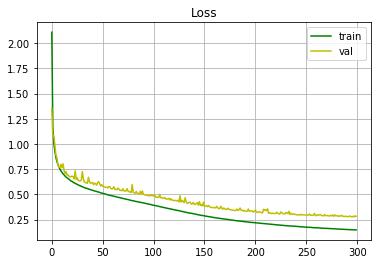

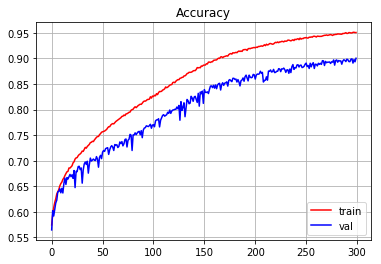

Done!


In [14]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [15]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 3s 913us/step
Test loss: 0.2776962734531768
Test accuracy: 0.9045718432510885


In [16]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])

#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [17]:
y_pred.shape

(2756, 2)

In [18]:
accuracy

0.9045718432510885

In [19]:
np.save("y_pred_raja_exp1.npy", y_pred)